In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [2]:
df = pd.read_csv(r"games.csv")

In [3]:
df.shape

(20058, 16)

In [4]:
display(df.describe())

,created_at,last_move_at,turns,white_rating,black_rating,opening_ply
count,2.005800e+04,2.005800e+04,20058.000000,20058.000000,20058.000000,20058.000000
mean,1.483617e+12,1.483618e+12,60.465999,1596.631868,1588.831987,4.816981
std,2.850151e+10,2.850140e+10,33.570585,291.253376,291.036126,2.797152
min,1.376772e+12,1.376772e+12,1.000000,784.000000,789.000000,1.000000
25%,1.477548e+12,1.477548e+12,37.000000,1398.000000,1391.000000,3.000000
50%,1.496010e+12,1.496010e+12,55.000000,1567.000000,1562.000000,4.000000
75%,1.503170e+12,1.503170e+12,79.000000,1793.000000,1784.000000,6.000000
max,1.504493e+12,1.504494e+12,349.000000,2700.000000,2723.000000,28.000000


In [5]:
df.dtypes

id                 object
rated                bool
created_at        float64
last_move_at      float64
turns               int64
victory_status     object
winner             object
increment_code     object
white_id           object
white_rating        int64
black_id           object
black_rating        int64
moves              object
opening_eco        object
opening_name       object
opening_ply         int64
dtype: object

# Converting time into correct format 

In [6]:
df['created_at'] = df['created_at'].apply(lambda x: datetime.timedelta(seconds=x))
df['created_at'] = df['created_at'].apply(lambda x: str(x).split(',')[-1])

df['last_move_at'] = df['last_move_at'].apply(lambda x: datetime.timedelta(seconds=x))
df['last_move_at'] = df['last_move_at'].apply(lambda x: str(x).split(',')[-1])

# Deleting inconsistent time data

In [7]:
temp = df['created_at'] == df['last_move_at']
df = df[~temp]

In [8]:
df.shape

(11510, 16)

In [9]:
df.columns

Index(['id', 'rated', 'created_at', 'last_move_at', 'turns', 'victory_status',
       'winner', 'increment_code', 'white_id', 'white_rating', 'black_id',
       'black_rating', 'moves', 'opening_eco', 'opening_name', 'opening_ply'],
      dtype='object')

# Keeping only the records which are rated

In [10]:
df = df[df['rated'] == True]

In [11]:
df.shape

(9283, 16)

# Top 10 Openings to play

(8870, 2)


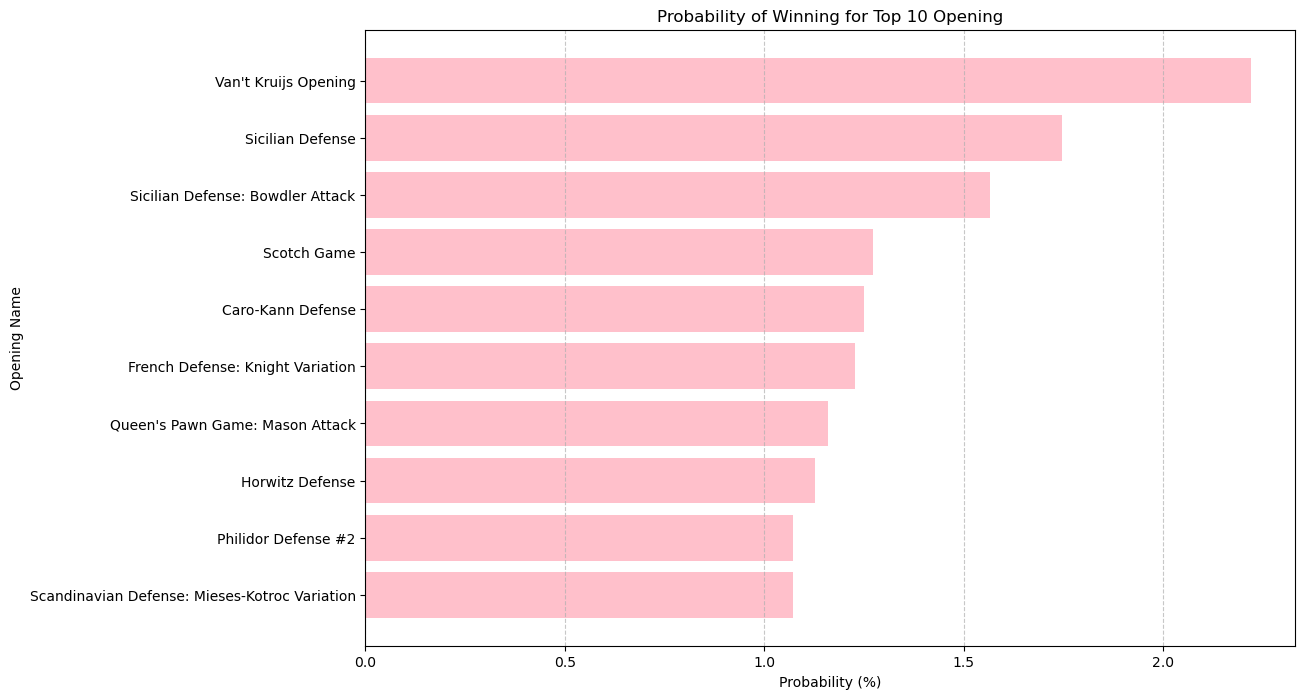

In [12]:
winners_df = df[df['victory_status'] != 'draw'][['winner', 'opening_name']]
print(winners_df.shape)

prob = (winners_df['opening_name'].value_counts(normalize='index')*100).reset_index().head(10)
prob.columns = ['opening_name','value']

plt.figure(figsize=(12, 8))
plt.barh(prob['opening_name'], prob['value'], color='pink')
plt.xlabel('Probability (%)')
plt.ylabel('Opening Name')
plt.title('Probability of Winning for Top 10 Opening')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Analysis based on ID

# Getting the rating of each player

In [13]:
common_ids = set(df['black_id']).intersection(set(df['white_id']))

black = df[df['black_id'].isin(common_ids)][['black_id','black_rating']]
white = df[df['white_id'].isin(common_ids)][['white_id','white_rating']]

black.rename(columns={'black_id': 'common_id'}, inplace=True)
white.rename(columns={'white_id': 'common_id'}, inplace=True)

bw = pd.merge(black,white,on='common_id',how='inner')

ratings = (pd.pivot_table(bw, index='common_id', values=['black_rating', 'white_rating'])
           .assign(avg_rating=lambda x: (x['black_rating'] + x['white_rating']) / 2)
           .round(2)
           .sort_values(by='avg_rating', ascending=False)
           .reset_index())

ratings.drop(columns=['black_rating','white_rating'],inplace=True)
ratings.columns = ['common_id','avg_rating']

# Top 10 players based on their average rating

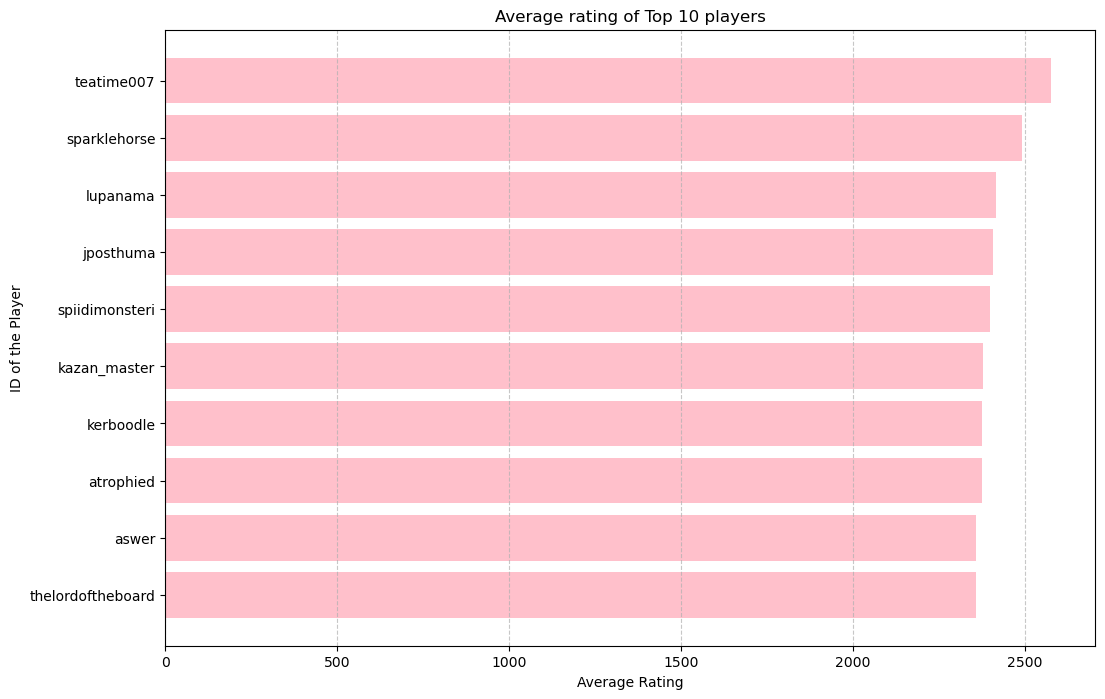

In [14]:
top_10_players = ratings.head(10)

plt.figure(figsize=(12, 8))
plt.barh(top_10_players['common_id'], top_10_players['avg_rating'], color='pink')
plt.ylabel('ID of the Player')
plt.xlabel('Average Rating')
plt.title('Average rating of Top 10 players')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Last 10 players based on their average rating

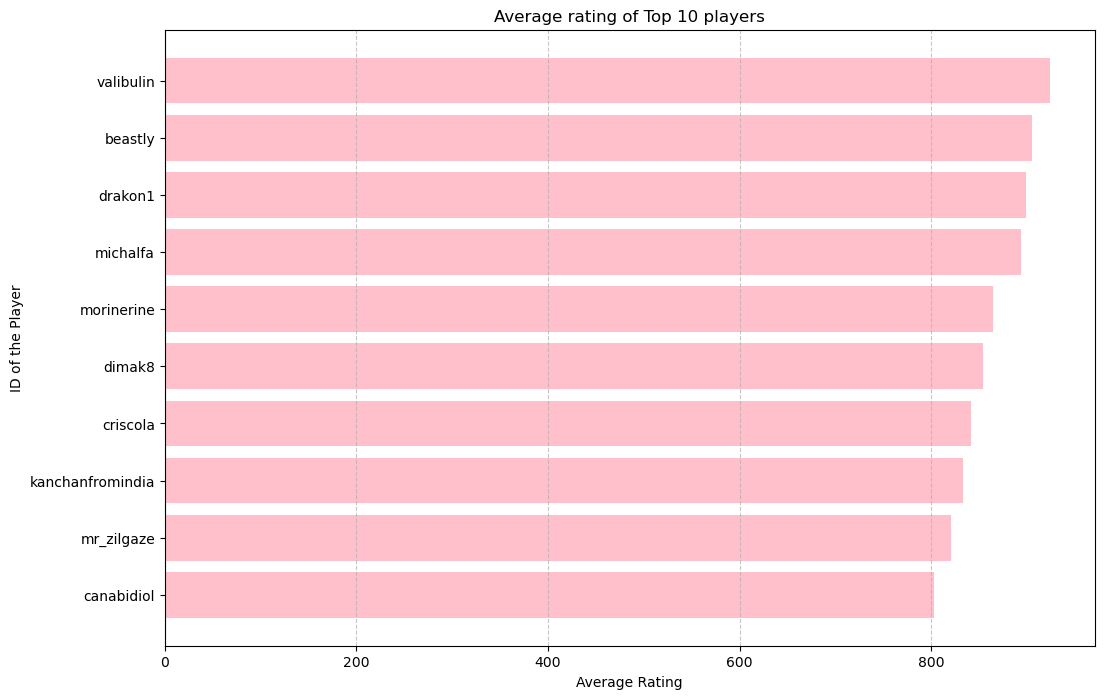

In [15]:
last_10_players = ratings.tail(10)

plt.figure(figsize=(12, 8))
plt.barh(last_10_players['common_id'], last_10_players['avg_rating'], color='pink')
plt.ylabel('ID of the Player')
plt.xlabel('Average Rating')
plt.title('Average rating of Top 10 players')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Getting the winning ratio of each player

In [16]:
win_counts = {}

for index, row in df.iterrows():
    winner_id = row['white_id'] if row['winner'] == 'white' else row['black_id']
    if winner_id in win_counts:
        win_counts[winner_id] += 1
    else:
        win_counts[winner_id] = 1

win_count = pd.DataFrame(list(win_counts.items()), columns=['player_id', 'win_count'])
win_count.value_counts().reset_index()
win_count.columns = ['common_id','win_ratio']

win_count.sort_values(by = 'win_ratio', ascending=False).head(10)

temp = pd.pivot_table(win_count,values = 'win_ratio', index='common_id')
temp['win_perc'] = (temp['win_ratio']/temp['win_ratio'].sum())*100
win_ratio = temp.sort_values(by='win_perc',ascending=False)

# Merging the two datasets 1(Average Rating of player) 2(Win % of the player)

In [17]:
players = pd.merge(ratings,win_ratio,left_on='common_id', right_on='common_id').drop(columns = 'win_ratio')

In [25]:
players.head()

,common_id,avg_rating,win_perc
0,teatime007,2575.25,0.043090
1,sparklehorse,2490.50,0.010772
2,lupanama,2416.00,0.086179
3,jposthuma,2406.00,0.021545
4,kazan_master,2377.75,0.021545


# Performing statistics on this merged dataset

In [18]:
# descriptive analysis
players.describe()

,avg_rating,win_perc
count,1076.000000,1076.000000
mean,1642.438457,0.054102
std,277.579775,0.070401
min,820.500000,0.010772
25%,1446.297500,0.010772
50%,1625.800000,0.021545
75%,1819.375000,0.064634
max,2575.250000,0.560164


In [19]:
correlation, p_value = pearsonr(players['avg_rating'], players['win_perc'])
print('Correlation: ',correlation)
print('P-value: ',p_value)

Correlation:  0.09170704306054876
P-value:  0.0026033300540254686


In [26]:
x = players['avg_rating'].values.reshape(-1, 1)
y = players['win_perc'].values

reg = LinearRegression().fit(x, y)
print('Regression Coefficient: ',reg.coef_[0], 'Intercept: ',reg.intercept_)

x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
print(model.summary())

Regression Coefficient:  2.3259068711707347e-05 Intercept:  0.015900585286705286
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     9.109
Date:                Wed, 07 Aug 2024   Prob (F-statistic):            0.00260
Time:                        22:07:32   Log-Likelihood:                 1333.5
No. Observations:                1076   AIC:                            -2663.
Df Residuals:                    1074   BIC:                            -2653.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

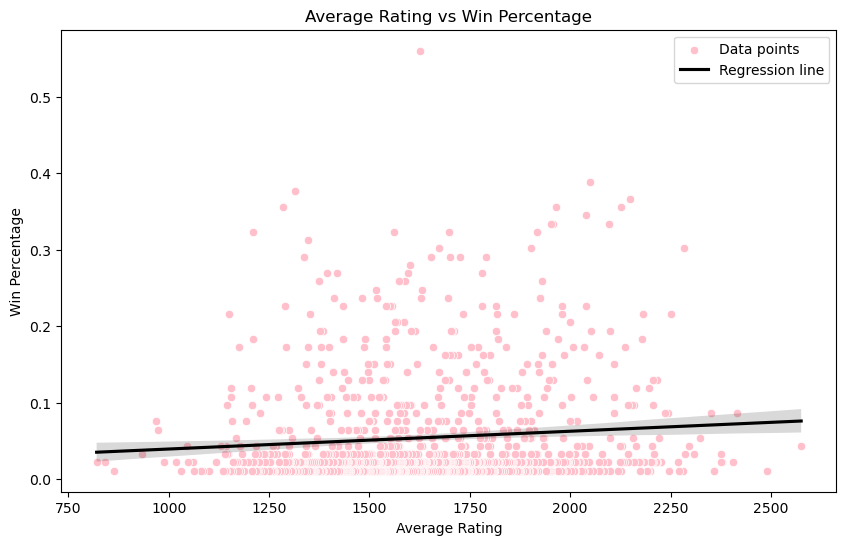

In [21]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='avg_rating', y='win_perc', data=players, color='pink', label='Data points')
sns.regplot(x='avg_rating', y='win_perc', data=players, scatter=False, color='black', label='Regression line')
plt.title('Average Rating vs Win Percentage')
plt.xlabel('Average Rating')
plt.ylabel('Win Percentage')
plt.legend()
plt.show()

# Dividing the dataset into 2

In [22]:
top_10_players_by_perc = players.sort_values(by = 'win_perc',ascending=False).head(10)
last_10_players_by_perc = players.sort_values(by = 'win_perc',ascending=False).tail(10)

# Top 10 players by percentage

C:\Users\Pavan Yadav\AppData\Local\Temp\ipykernel_13704\391556953.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='win_perc', y='common_id', data=top_10_players_by_perc, palette='viridis', label='Top 10 Players')


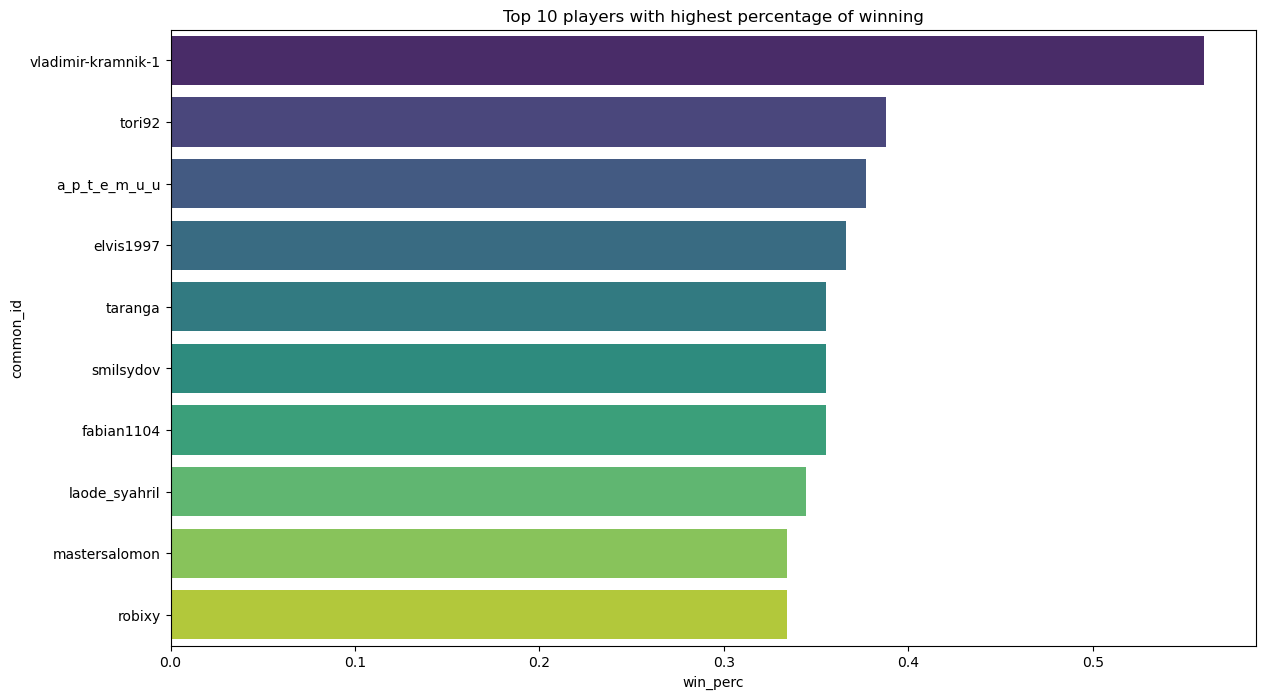

In [23]:
plt.figure(figsize=(14, 8))
sns.barplot(x='win_perc', y='common_id', data=top_10_players_by_perc, palette='viridis', label='Top 10 Players')
plt.title("Top 10 players with highest percentage of winning")
plt.show()

# Last 10 players by percentage

C:\Users\Pavan Yadav\AppData\Local\Temp\ipykernel_13704\1223102451.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='win_perc', y='common_id', data=last_10_players_by_perc, palette='magma', label='Last 10 Players')


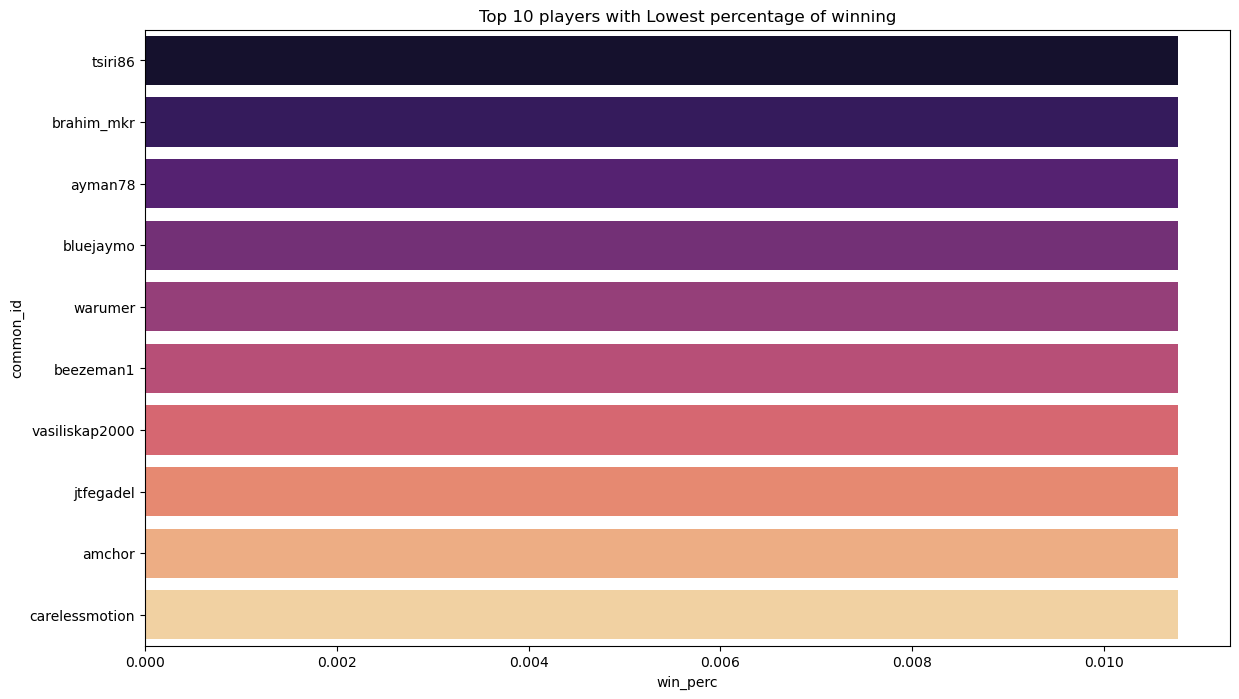

In [24]:
plt.figure(figsize=(14, 8))
sns.barplot(x='win_perc', y='common_id', data=last_10_players_by_perc, palette='magma', label='Last 10 Players')
plt.title("Top 10 players with Lowest percentage of winning")
plt.show()